<a href="https://colab.research.google.com/github/NancyFulda/towards-neural-programming-interfaces/blob/master/notebooks/politics/politics_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Notebook training NPI on Cat-Induction/Cat-Avoidance

## Setup

### Prerequisite setup for Colab:

*   Ensure you selected a runtime with a GPU. You can do that by clicking Runtime -> Change runtime type ->  Hardware Accelerator -> GPU
*   After running the setup code in this section, restart the runtime by clicking Runtime -> Restart runtime.

After you have done the prerequisite setup, you will not need to rerun this section again.

### For local machines with CUDA:

Run the following code if you do not have the towards-neural-programming-interfaces repo. 
If you already have the repository, make sure you ran `./install_dependencies.sh` in the repo root.
After you done so, skip to the [Post Setup section](#post-setup)

In [ ]:
!git clone https://github.com/NancyFulda/towards-neural-programming-interfaces.git
!cd towards-neural-programming-interfaces && ./install_dependencies.sh

### Post setup

***Note: You will need to restart the runtime on Colab to continue***

Click on Runtime -> Restart Runtime to do so.


In [1]:
# For dev purposes, enable autoreload of modules
%load_ext autoreload

In [2]:
import pandas as pd
import torch

%autoreload

# Constructing training dataset
from npi.dataset import NPIDatasetConstructor, NPIDatasetLoader

# Models
from npi.models import NPITrainingModels

# Training NPI
from npi.training import NPIStyleTrainer, NPITrainer

# Configuration
from npi.config import NPIConfig


/home/cs401r/.local/share/virtualenvs/towards-neural-programming-interfaces-UdnRbY7B/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note that each step in training an NPI is conditioned on the variable toggles, so you can disable certain steps to not redo them again when running the whole notebook.

In [3]:
# Toggle steps
construct = True
train_class = True
test_class = True
train_npi = True


Below is where an NPIConfig object is defined. It holds configuration for the NPI that you can use for the different NPI training steps. Notice that it is injected intothe NPITrainingModels class. That class will load the necessary models using the configuration defined in NPIConfig.

In [4]:
model_layers = [5, 11]

device = torch.device(f"cuda:0")
config_induction = NPIConfig(
    device,
    gpt_model="gpt2",
    perturbation_indices=model_layers,
    npi_name="cat_induction",
    window_size=10
)


In [5]:
# Initialize models for training and testing
models = NPITrainingModels(
    config_induction,
)

## Create Dataset

In [8]:
if construct:
    construct_data = NPIDatasetConstructor(config_induction)
    construct_data.construct_target_word_dataset("../../smaller_wiki_books_reddit_shuffled.txt", num_sentences=1000) 


Using cuda:0
gpu_device is cuda:0
and so it begins
iterations: 1; target words data: 0/500, generic data: 1/500, data written: 1
iterations: 51; target words data: 9/500, generic data: 11/500, data written: 20
iterations: 101; target words data: 18/500, generic data: 22/500, data written: 40
iterations: 151; target words data: 26/500, generic data: 32/500, data written: 58
iterations: 201; target words data: 37/500, generic data: 45/500, data written: 82
iterations: 251; target words data: 45/500, generic data: 55/500, data written: 100
iterations: 301; target words data: 57/500, generic data: 69/500, data written: 126
iterations: 351; target words data: 68/500, generic data: 82/500, data written: 150
iterations: 401; target words data: 77/500, generic data: 93/500, data written: 170
iterations: 451; target words data: 82/500, generic data: 99/500, data written: 181
iterations: 501; target words data: 87/500, generic data: 105/500, data written: 192
iterations: 551; target words data: 

## Train classifier from Dataset



In [9]:
model_loader = NPITrainingModels(config_induction)
dataset_loader = NPIDatasetLoader(config_induction, target="style")
style_trainer = NPIStyleTrainer(config_induction, class_lr=1e-5)
classifier = None
if train_class:
    classifier = style_trainer.train_classifier(
        model_loader,
        dataset_loader,
        num_epochs=5,
        #continue_epoch=4,  # Set epoch of classifier to load to continue training.
    )


Classifier INIT
Defining classifier model
Loading style_model weights from models/npi_models/cat_induction_style_model_004.pth
Initializing class loss
Training


epoch: 0 train_loss=10759227.05 test_loss=14135949.56 test_accuracy=0.95:  98%|█████████▊| 146/149 [01:14<00:01,  2.02it/s]

Saving Style Classifier epoch 0


Saving Style Classifier epoch 4
Epoch train loss history ==  [10651556.02375, 5462318.7125, 3495854.1929166666, 2694482.1910416665, 1686640.0747916666]


### Test Classifier


In [10]:
_, test_loader, _, _ = dataset_loader.load_train_and_test_dataloaders()

classifier = model_loader.load_style_classifier() if not classifier else classifier
# When output=True, it will log the following in models/npi_models/style_classifier_output.log:
#   (generated text from the dataset)
#   truth={target_label} actual={model_output}
style_trainer.test_model(test_loader, classifier, torch.nn.BCELoss(), output=True)


(11598677.56125, 0.96)

## Training NPI

In [6]:
%load_ext pytorch_memlab

NPI INITIALIZATION
GenerationClassifier INIT
Defining GenerationClassifier model
Classifier INIT
Defining classifier model
Loading style_model weights from models/npi_models/cat_induction_style_model_004.pth
Initializing GPT2WithNPI model with tokenizer -- not being placed on GPU until npi loss evaluation
Training


epoch:0, gen_class_loss:13861.38, npi_loss:243329.66: 100%|██████████| 187/187 [02:07<00:00,  1.47it/s]

Testing
Saving NPI Model
Saving GenerationClassifier Model


epoch:5, gen_class_loss:13648.05, npi_loss:168336.50: 100%|██████████| 187/187 [02:09<00:00,  1.45it/s]

Testing


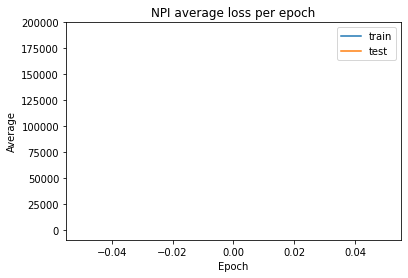

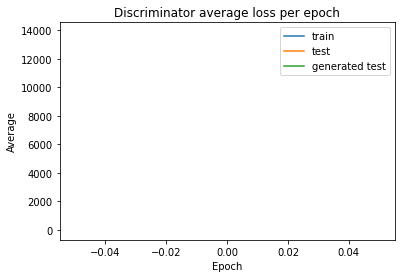

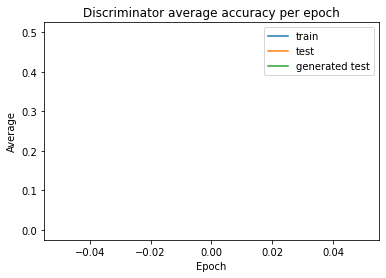

In [6]:
# %%mlrun 
# from pytorch_memlab import profile, set_target_gpu
# set_target_gpu(1)
num_epochs = 6
split_ratio = 0.25
batch_size = 4
headstart = 0  # set at 0 for debugging

if train_npi:
    trainer = NPITrainer(config_induction, batch_size=batch_size, headstart=headstart)
    dataset_loader = NPIDatasetLoader(config_induction, split_ratio=split_ratio)
    trainer.train_adversarial_npi(models, num_epochs, dataset_loader)


In [7]:
from pytorch_memlab import MemReporter
reporter = MemReporter(models.gpt2_with_npi)
reporter.report(device=config_induction.device)

Element type                                            Size  Used MEM
-------------------------------------------------------------------------------
Storage on cuda:0
npi_model.first_linear.0.weight                 (50, 153600)    29.30M
npi_model.first_linear.0.weight.grad            (50, 153600)    29.30M
npi_model.first_linear.0.bias                          (50,)   512.00B
npi_model.first_linear.0.bias.grad                     (50,)   512.00B
npi_model.second_linear.0.weight                    (50, 50)    10.00K
npi_model.second_linear.0.weight.grad               (50, 50)    10.00K
npi_model.second_linear.0.bias                         (50,)   512.00B
npi_model.second_linear.0.bias.grad                    (50,)   512.00B
npi_model.third_linear.0.weight                     (25, 50)     5.00K
npi_model.third_linear.0.weight.grad                (25, 50)     5.00K
npi_model.third_linear.0.bias                          (25,)   512.00B
npi_model.third_linear.0.bias.grad                

/home/cs401r/.local/share/virtualenvs/towards-neural-programming-interfaces-UdnRbY7B/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:102: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


## Test NPI

Using the model loader, you can directly generate NPI text.


In [13]:
text = "The cat is a great animal. I love it as my pet so much! How about you?"
print(f"\nOriginal GPT2 output: '{text}'\n{models.gpt2_generate_text(text)}")


Model: GPT 2 Vanilla: 100%|██████████| 100/100 [00:00<00:00, 122.60it/s]



Original GPT2 output: 'The cat is a great animal. I love it as my pet so much! How about you?'


I'm a big fan of the idea of a "real" world.

The "real" world is not the real world.

The world is not a perfect place.

The world is a better place if you're a good person.

"I'm not going to be able to do that. I think it's a good idea to have a lot of people who are not going to be able to afford to buy a new car.

"


In [14]:
text = "I hate cats. Can we talk about something else?"
print(f"\nNPI GPT2 output: '{text}'\n{models.npi_generate_text(text)}")

Model: GPT2 with NPI: 100%|██████████| 100/100 [00:01<00:00, 57.75it/s]


NPI GPT2 output: 'I hate cats. Can we talk about something else?'


I think it's a good idea to have a lot of people who are not going to be able to afford to buy a new car.

"I'm not sure if it's a good idea to use a different name for the same thing.

The first thing to do is to get the best possible performance out of your system.

The best way to get started is to start with the basics.

The first thing you need to do is to install the
